In [1]:
# Cell 1: Import Libraries and Setup
import re
import unicodedata
from collections import Counter, defaultdict
import pandas as pd
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib.request
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cell 2: Configure Bangla Fonts
def setup_bangla_fonts():
    """Download and install Bangla fonts for matplotlib"""
    font_dir = '/usr/share/fonts/truetype/bangla/'
    os.makedirs(font_dir, exist_ok=True)

    # Download Noto Sans Bengali font
    font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansBengali/NotoSansBengali-Regular.ttf'
    font_path = f'{font_dir}NotoSansBengali-Regular.ttf'

    if not os.path.exists(font_path):
        print("Downloading Bangla font...")
        urllib.request.urlretrieve(font_url, font_path)
        print("Font downloaded successfully!")

        # Clear matplotlib font cache
        import matplotlib.font_manager as fm
        import matplotlib.pyplot as plt

        try:
            import shutil
            cache_dir = fm.get_cachedir()
            if os.path.exists(cache_dir):
                shutil.rmtree(cache_dir)
            fm.FontManager.__init__(fm.fontManager)
            print("Font cache rebuilt successfully!")
        except Exception as e:
            print(f"Font cache rebuild failed: {e}")
            print("You may need to restart the runtime for fonts to work properly")

    return 'Noto Sans Bengali'

# Setup fonts
font_name = setup_bangla_fonts()
plt.rcParams['font.family'] = [font_name, 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

print(f"Font configured: {font_name}")
print("Setup completed successfully!")

Font downloaded successfully!
Font cache rebuild failed: module 'matplotlib.font_manager' has no attribute 'get_cachedir'
You may need to restart the runtime for fonts to work properly
Font configured: Noto Sans Bengali
Setup completed successfully!


In [4]:
# Cell 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# Define base path for your datasets
DRIVE_BASE_PATH = "/content/drive/MyDrive/BT/REC_OUTPUTS"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [5]:
# Cell 4: Enhanced BanglaTokenizer Class
class BanglaTokenizer:
    """
    Enhanced Bangla Text Tokenizer with comparison capabilities
    """

    def __init__(self):
        # Word-level tokenization patterns
        self.word_patterns = {
            'WORD': r'[\u0980-\u09FF]+',  # Bangla Unicode block
            'NUMBER': r'[\u09E6-\u09EF]+',  # Bangla digits
            'PUNCTUATION': r'[।,?!;:]|\u0964|\u0965',  # Bangla and borrowed punctuation
            'WHITESPACE': r'\s+',  # Standard whitespace
            'LATIN_WORD': r'[a-zA-Z]+',  # Latin characters
            'ARABIC_NUM': r'[0-9]+',  # Arabic numerals
            'OTHER': r'[^\s]'  # Any other character
        }

        # Character-level tokenization patterns
        self.char_patterns = {
            'COMPOUND': r'[\u0995-\u09B9](?:\u09CD[\u0995-\u09B9])+',  # Compound consonants
            'CONSONANT_VOWEL': r'[\u0995-\u09B9][\u09BE-\u09CC]',  # Consonant + vowel diacritic
            'CONSONANT': r'[\u0995-\u09B9]',  # Individual consonants
            'INDEPENDENT_VOWEL': r'[\u0985-\u0994]',  # Independent vowels
            'DEPENDENT_VOWEL': r'[\u09BE-\u09CC]',  # Dependent vowel signs
            'MODIFIER': r'[\u09BC\u09CD\u09D7]',  # Modifiers and diacritics
            'BANGLA_DIGIT': r'[\u09E6-\u09EF]',  # Bangla digits
            'PUNCTUATION': r'[।,?!;:]|\u0964|\u0965',  # Punctuation
            'WHITESPACE': r'\s',  # Individual whitespace
            'LATIN_CHAR': r'[a-zA-Z]',  # Latin characters
            'ARABIC_DIGIT': r'[0-9]',  # Arabic numerals
            'OTHER': r'.'  # Any other character
        }

        # Compile patterns for efficiency
        self.word_regex = self._compile_patterns(self.word_patterns)
        self.char_regex = self._compile_patterns(self.char_patterns)

    def _compile_patterns(self, patterns: Dict[str, str]) -> List[Tuple[str, re.Pattern]]:
        """Compile regex patterns with their labels"""
        return [(label, re.compile(pattern)) for label, pattern in patterns.items()]

    def normalize_text(self, text: str) -> str:
        """Apply Unicode NFC normalization"""
        return unicodedata.normalize('NFC', text)

    def word_tokenize(self, text: str) -> List[Dict[str, str]]:
        """Perform word-level tokenization"""
        normalized_text = self.normalize_text(text)
        tokens = []
        position = 0

        while position < len(normalized_text):
            matched = False

            for label, pattern in self.word_regex:
                match = pattern.match(normalized_text, position)
                if match:
                    token_text = match.group()
                    if label != 'WHITESPACE' or token_text.strip():
                        tokens.append({
                            'token': token_text,
                            'type': label,
                            'position': position,
                            'length': len(token_text)
                        })
                    position = match.end()
                    matched = True
                    break

            if not matched:
                tokens.append({
                    'token': normalized_text[position],
                    'type': 'UNKNOWN',
                    'position': position,
                    'length': 1
                })
                position += 1

        return tokens

    def character_tokenize(self, text: str) -> List[Dict[str, str]]:
        """Perform character-level tokenization"""
        normalized_text = self.normalize_text(text)
        tokens = []
        position = 0

        while position < len(normalized_text):
            matched = False

            for label, pattern in self.char_regex:
                match = pattern.match(normalized_text, position)
                if match:
                    token_text = match.group()
                    tokens.append({
                        'token': token_text,
                        'type': label,
                        'position': position,
                        'length': len(token_text)
                    })
                    position = match.end()
                    matched = True
                    break

            if not matched:
                tokens.append({
                    'token': normalized_text[position],
                    'type': 'UNKNOWN',
                    'position': position,
                    'length': 1
                })
                position += 1

        return tokens

    def analyze_tokens(self, tokens: List[Dict[str, str]]) -> Dict:
        """Analyze tokenization results"""
        token_texts = [t['token'] for t in tokens]
        token_types = [t['type'] for t in tokens]

        total_tokens = len(tokens)
        unique_tokens = len(set(token_texts))
        token_freq = Counter(token_texts)
        type_freq = Counter(token_types)
        most_common_tokens = token_freq.most_common(15)

        return {
            'total_tokens': total_tokens,
            'unique_tokens': unique_tokens,
            'token_frequency': token_freq,
            'type_frequency': type_freq,
            'most_common_tokens': most_common_tokens,
            'tokens': tokens,
            'type_token_ratio': unique_tokens / total_tokens if total_tokens > 0 else 0
        }

print("Enhanced BanglaTokenizer class defined successfully!")

Enhanced BanglaTokenizer class defined successfully!


In [6]:
# Cell 5: File Loading and Dataset Management Functions
class DatasetManager:
    """Manages multiple datasets and their files"""

    def __init__(self, base_path: str):
        self.base_path = base_path
        self.datasets = ['D1', 'D2', 'D3', 'D4', 'D5']
        self.file_types = ['ground_truth', 'clean_output', 'fast_output', 'ruled_output']

    def load_text_file(self, file_path: str) -> Optional[str]:
        """Load text from file with proper encoding"""
        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")
            return None

        encodings = ['utf-8', 'utf-16', 'utf-8-sig', 'cp1252']

        for encoding in encodings:
            try:
                with open(file_path, 'r', encoding=encoding) as f:
                    content = f.read().strip()
                    if content:
                        return content
            except (UnicodeDecodeError, UnicodeError):
                continue
            except Exception as e:
                print(f"Error reading {file_path}: {str(e)}")
                return None

        print(f"Could not decode file: {file_path}")
        return None

    def get_file_path(self, dataset: str, file_type: str) -> str:
        """Get full file path for dataset and file type"""
        filename = f"{dataset}_{file_type}.txt"
        return os.path.join(self.base_path, filename)

    def load_dataset_files(self, dataset: str) -> Dict[str, str]:
        """Load all files for a specific dataset"""
        files_data = {}
        print(f"\nLoading files for {dataset}:")

        for file_type in self.file_types:
            file_path = self.get_file_path(dataset, file_type)
            content = self.load_text_file(file_path)

            if content is not None:
                files_data[file_type] = content
                print(f"  ✓ {file_type}: {len(content)} characters")
            else:
                print(f"  ✗ {file_type}: Failed to load")

        return files_data

    def load_all_datasets(self) -> Dict[str, Dict[str, str]]:
        """Load all datasets and their files"""
        all_data = {}
        print("Loading all datasets...")

        for dataset in self.datasets:
            dataset_files = self.load_dataset_files(dataset)
            if dataset_files:  # Only add if we have some files
                all_data[dataset] = dataset_files
            else:
                print(f"Warning: No files loaded for {dataset}")

        print(f"\nLoaded {len(all_data)} datasets successfully!")
        return all_data

    def verify_datasets(self) -> bool:
        """Verify that all expected files exist"""
        missing_files = []

        for dataset in self.datasets:
            for file_type in self.file_types:
                file_path = self.get_file_path(dataset, file_type)
                if not os.path.exists(file_path):
                    missing_files.append(file_path)

        if missing_files:
            print("Missing files:")
            for file in missing_files:
                print(f"  - {file}")
            return False
        else:
            print("All expected files found!")
            return True

In [7]:
# Cell 6: Initialize Dataset Manager
# UPDATE THIS PATH TO YOUR ACTUAL GOOGLE DRIVE FOLDER
DRIVE_BASE_PATH = "/content/drive/MyDrive/BT/REC_OUTPUTS/"

# Initialize dataset manager
dataset_manager = DatasetManager(DRIVE_BASE_PATH)

# Verify files exist
print("Verifying dataset files...")
files_exist = dataset_manager.verify_datasets()

if not files_exist:
    print("\nPlease ensure all dataset files are uploaded to your Google Drive folder.")
    print("Expected file structure:")
    for dataset in dataset_manager.datasets:
        print(f"  {dataset}:")
        for file_type in dataset_manager.file_types:
            print(f"    - {dataset}_{file_type}.txt")
else:
    print("Dataset verification completed successfully!")

Verifying dataset files...
All expected files found!
Dataset verification completed successfully!


In [8]:
# Cell 7: Token Comparison Functions
class TokenComparator:
    """Compare tokenization results between different outputs and ground truth"""

    def __init__(self):
        self.tokenizer = BanglaTokenizer()

    def calculate_token_metrics(self, predicted_tokens: List[str], ground_truth_tokens: List[str]) -> Dict:
        """Calculate precision, recall, F1 for token comparison"""
        predicted_set = set(predicted_tokens)
        ground_truth_set = set(ground_truth_tokens)

        # Calculate metrics
        intersection = predicted_set.intersection(ground_truth_set)

        precision = len(intersection) / len(predicted_set) if len(predicted_set) > 0 else 0
        recall = len(intersection) / len(ground_truth_set) if len(ground_truth_set) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predicted_count': len(predicted_tokens),
            'ground_truth_count': len(ground_truth_tokens),
            'intersection_count': len(intersection),
            'unique_predicted': len(predicted_set),
            'unique_ground_truth': len(ground_truth_set)
        }

    def compare_tokenization(self, text1: str, text2: str, level: str = 'word') -> Dict:
        """Compare tokenization between two texts"""
        if level == 'word':
            tokens1 = self.tokenizer.word_tokenize(text1)
            tokens2 = self.tokenizer.word_tokenize(text2)
        else:  # character level
            tokens1 = self.tokenizer.character_tokenize(text1)
            tokens2 = self.tokenizer.character_tokenize(text2)

        # Extract token text (excluding whitespace for comparison)
        tokens1_text = [t['token'] for t in tokens1 if t['type'] != 'WHITESPACE']
        tokens2_text = [t['token'] for t in tokens2 if t['type'] != 'WHITESPACE']

        return self.calculate_token_metrics(tokens1_text, tokens2_text)

    def analyze_dataset_file(self, text: str) -> Dict:
        """Analyze a single text file"""
        word_tokens = self.tokenizer.word_tokenize(text)
        char_tokens = self.tokenizer.character_tokenize(text)

        word_analysis = self.tokenizer.analyze_tokens(word_tokens)
        char_analysis = self.tokenizer.analyze_tokens(char_tokens)

        return {
            'word_analysis': word_analysis,
            'char_analysis': char_analysis,
            'text_length': len(text),
            'text_preview': text[:100] + "..." if len(text) > 100 else text
        }


In [9]:
# Cell 8: Results Display Functions
def print_dataset_analysis(dataset_name: str, file_type: str, analysis: Dict):
    """Print analysis results for a single dataset file"""
    print(f"\n{'='*60}")
    print(f"ANALYSIS: {dataset_name} - {file_type.upper()}")
    print(f"{'='*60}")

    word_analysis = analysis['word_analysis']
    char_analysis = analysis['char_analysis']

    print(f"Text Length: {analysis['text_length']} characters")
    print(f"Preview: {analysis['text_preview']}")

    print(f"\nWORD-LEVEL TOKENIZATION:")
    print(f"  • Total tokens: {word_analysis['total_tokens']:,}")
    print(f"  • Unique tokens: {word_analysis['unique_tokens']:,}")
    print(f"  • Type-token ratio: {word_analysis['type_token_ratio']:.3f}")

    print(f"\nCHARACTER-LEVEL TOKENIZATION:")
    print(f"  • Total tokens: {char_analysis['total_tokens']:,}")
    print(f"  • Unique tokens: {char_analysis['unique_tokens']:,}")
    print(f"  • Type-token ratio: {char_analysis['type_token_ratio']:.3f}")

    print(f"\nWORD TOKEN TYPE DISTRIBUTION:")
    for token_type, count in word_analysis['type_frequency'].items():
        percentage = (count / word_analysis['total_tokens']) * 100
        print(f"  • {token_type:<15}: {count:>4} ({percentage:>5.1f}%)")

    print(f"\nTOP 10 MOST FREQUENT WORDS:")
    for i, (token, count) in enumerate(word_analysis['most_common_tokens'][:10], 1):
        print(f"  {i:>2}. '{token}' → {count} times")

def print_comparison_results(dataset_name: str, comparison_results: Dict):
    """Print comparison results for a dataset"""
    print(f"\n{'='*80}")
    print(f"COMPARISON RESULTS: {dataset_name}")
    print(f"{'='*80}")

    file_types = ['clean_output', 'fast_output', 'ruled_output']

    for file_type in file_types:
        if file_type in comparison_results:
            print(f"\n{file_type.upper()} vs GROUND_TRUTH:")

            word_comp = comparison_results[file_type]['word']
            char_comp = comparison_results[file_type]['char']

            print(f"  Word-level comparison:")
            print(f"    • Precision: {word_comp['precision']:.3f}")
            print(f"    • Recall: {word_comp['recall']:.3f}")
            print(f"    • F1-Score: {word_comp['f1_score']:.3f}")
            print(f"    • Predicted tokens: {word_comp['predicted_count']:,}")
            print(f"    • Ground truth tokens: {word_comp['ground_truth_count']:,}")

            print(f"  Character-level comparison:")
            print(f"    • Precision: {char_comp['precision']:.3f}")
            print(f"    • Recall: {char_comp['recall']:.3f}")
            print(f"    • F1-Score: {char_comp['f1_score']:.3f}")
            print(f"    • Predicted tokens: {char_comp['predicted_count']:,}")
            print(f"    • Ground truth tokens: {char_comp['ground_truth_count']:,}")

print("Comparison and analysis functions defined successfully!")

Comparison and analysis functions defined successfully!


In [10]:
# Cell 9: Main Processing Pipeline
def process_all_datasets():
    """Process all datasets and perform analysis"""

    # Initialize components
    comparator = TokenComparator()

    # Load all datasets
    all_datasets = dataset_manager.load_all_datasets()

    if not all_datasets:
        print("No datasets loaded. Please check your file paths.")
        return None

    # Store all results
    all_results = {}
    all_comparisons = {}

    # Process each dataset
    for dataset_name, dataset_files in all_datasets.items():
        print(f"\n{'#'*80}")
        print(f"PROCESSING DATASET: {dataset_name}")
        print(f"{'#'*80}")

        dataset_results = {}
        dataset_comparisons = {}

        # Analyze each file in the dataset
        for file_type, text_content in dataset_files.items():
            analysis = comparator.analyze_dataset_file(text_content)
            dataset_results[file_type] = analysis

            # Print individual analysis
            print_dataset_analysis(dataset_name, file_type, analysis)

        # Perform comparisons with ground truth if available
        if 'ground_truth' in dataset_files:
            ground_truth_text = dataset_files['ground_truth']

            for file_type in ['clean_output', 'fast_output', 'ruled_output']:
                if file_type in dataset_files:
                    # Word-level comparison
                    word_comparison = comparator.compare_tokenization(
                        dataset_files[file_type],
                        ground_truth_text,
                        level='word'
                    )

                    # Character-level comparison
                    char_comparison = comparator.compare_tokenization(
                        dataset_files[file_type],
                        ground_truth_text,
                        level='character'
                    )

                    dataset_comparisons[file_type] = {
                        'word': word_comparison,
                        'char': char_comparison
                    }

            # Print comparison results
            print_comparison_results(dataset_name, dataset_comparisons)

        # Store results
        all_results[dataset_name] = dataset_results
        all_comparisons[dataset_name] = dataset_comparisons

    return all_results, all_comparisons


In [11]:
# Cell 10: Execute the Main Pipeline
print("Starting comprehensive dataset analysis...")
print("This will process all datasets and generate detailed reports.")
print("\nMake sure your DRIVE_BASE_PATH is correctly set!")

# Run the main processing pipeline
results, comparisons = process_all_datasets()

if results:
    print(f"\n{'='*80}")
    print("PROCESSING COMPLETED SUCCESSFULLY!")
    print(f"{'='*80}")
    print(f"• Processed {len(results)} datasets")
    print(f"• Generated individual analyses for each file")
    print(f"• Performed comparisons with ground truth")
    print("• Ready for summary analysis and visualization")
else:
    print("Processing failed. Please check your file paths and data.")

Starting comprehensive dataset analysis...
This will process all datasets and generate detailed reports.

Make sure your DRIVE_BASE_PATH is correctly set!
Loading all datasets...

Loading files for D1:
  ✓ ground_truth: 1106 characters
  ✓ clean_output: 743 characters
  ✓ fast_output: 750 characters
  ✓ ruled_output: 691 characters

Loading files for D2:
  ✓ ground_truth: 756 characters
  ✓ clean_output: 684 characters
  ✓ fast_output: 679 characters
  ✓ ruled_output: 658 characters

Loading files for D3:
  ✓ ground_truth: 692 characters
  ✓ clean_output: 757 characters
  ✓ fast_output: 760 characters
  ✓ ruled_output: 723 characters

Loading files for D4:
  ✓ ground_truth: 674 characters
  ✓ clean_output: 604 characters
  ✓ fast_output: 689 characters
  ✓ ruled_output: 690 characters

Loading files for D5:
  ✓ ground_truth: 279 characters
  ✓ clean_output: 273 characters
  ✓ fast_output: 267 characters
  ✓ ruled_output: 287 characters

Loaded 5 datasets successfully!

################

In [12]:
# Cell 11: Summary Analysis Functions
def create_summary_dataframes(results, comparisons):
    """Create summary DataFrames for analysis"""

    # Individual file statistics
    file_stats = []

    for dataset_name, dataset_results in results.items():
        for file_type, analysis in dataset_results.items():
            word_analysis = analysis['word_analysis']
            char_analysis = analysis['char_analysis']

            file_stats.append({
                'dataset': dataset_name,
                'file_type': file_type,
                'text_length': analysis['text_length'],
                'word_total_tokens': word_analysis['total_tokens'],
                'word_unique_tokens': word_analysis['unique_tokens'],
                'word_type_token_ratio': word_analysis['type_token_ratio'],
                'char_total_tokens': char_analysis['total_tokens'],
                'char_unique_tokens': char_analysis['unique_tokens'],
                'char_type_token_ratio': char_analysis['type_token_ratio']
            })

    file_stats_df = pd.DataFrame(file_stats)

    # Comparison statistics
    comparison_stats = []

    for dataset_name, dataset_comparisons in comparisons.items():
        for file_type, comparison_data in dataset_comparisons.items():
            word_comp = comparison_data['word']
            char_comp = comparison_data['char']

            comparison_stats.append({
                'dataset': dataset_name,
                'file_type': file_type,
                'word_precision': word_comp['precision'],
                'word_recall': word_comp['recall'],
                'word_f1_score': word_comp['f1_score'],
                'char_precision': char_comp['precision'],
                'char_recall': char_comp['recall'],
                'char_f1_score': char_comp['f1_score']
            })

    comparison_stats_df = pd.DataFrame(comparison_stats)

    return file_stats_df, comparison_stats_df

def print_overall_summary(file_stats_df, comparison_stats_df):
    """Print overall summary statistics"""
    print(f"\n{'='*100}")
    print("OVERALL DATASET SUMMARY")
    print(f"{'='*100}")

    # File statistics summary
    print("\nFILE STATISTICS SUMMARY:")
    print("-" * 50)

    # Group by file type
    file_type_summary = file_stats_df.groupby('file_type').agg({
        'text_length': ['mean', 'std', 'min', 'max'],
        'word_total_tokens': ['mean', 'std'],
        'word_type_token_ratio': ['mean', 'std'],
        'char_total_tokens': ['mean', 'std'],
        'char_type_token_ratio': ['mean', 'std']
    }).round(3)

    print(file_type_summary)

    # Comparison summary
    if not comparison_stats_df.empty:
        print(f"\nCOMPARISON SUMMARY (vs Ground Truth):")
        print("-" * 50)

        comparison_summary = comparison_stats_df.groupby('file_type').agg({
            'word_precision': ['mean', 'std'],
            'word_recall': ['mean', 'std'],
            'word_f1_score': ['mean', 'std'],
            'char_precision': ['mean', 'std'],
            'char_recall': ['mean', 'std'],
            'char_f1_score': ['mean', 'std']
        }).round(3)

        print(comparison_summary)

        # Best performing methods
        print(f"\nBEST PERFORMING METHODS:")
        print("-" * 30)

        word_f1_best = comparison_stats_df.loc[comparison_stats_df['word_f1_score'].idxmax()]
        char_f1_best = comparison_stats_df.loc[comparison_stats_df['char_f1_score'].idxmax()]

        print(f"Best Word-level F1: {word_f1_best['file_type']} ({word_f1_best['dataset']}) - F1: {word_f1_best['word_f1_score']:.3f}")
        print(f"Best Char-level F1: {char_f1_best['file_type']} ({char_f1_best['dataset']}) - F1: {char_f1_best['char_f1_score']:.3f}")

        # Average performance by method
        avg_performance = comparison_stats_df.groupby('file_type')[['word_f1_score', 'char_f1_score']].mean().round(3)
        print(f"\nAVERAGE F1-SCORES BY METHOD:")
        print(avg_performance)


In [15]:
# Cell 12: Generate Summary Analysis
if results and comparisons:
    print("Generating summary analysis...")

    # Create summary DataFrames
    file_stats_df, comparison_stats_df = create_summary_dataframes(results, comparisons)

    # Print overall summary
    print_overall_summary(file_stats_df, comparison_stats_df)

    # Save summary to CSV
    file_stats_df.to_csv('/content/drive/MyDrive/BT/REC_OUTPUTS/RES/file_statistics_summary.csv', index=False, encoding='utf-8')
    comparison_stats_df.to_csv('/content/drive/MyDrive/BT/REC_OUTPUTS/RES/comparison_summary.csv', index=False, encoding='utf-8')

    print(f"\nSummary files saved:")
    print("• file_statistics_summary.csv")
    print("• comparison_summary.csv")

    print(f"\nDataFrames created successfully!")
    print(f"• File stats shape: {file_stats_df.shape}")
    print(f"• Comparison stats shape: {comparison_stats_df.shape}")
else:
    print("No results available for summary analysis.")

Generating summary analysis...

OVERALL DATASET SUMMARY

FILE STATISTICS SUMMARY:
--------------------------------------------------
             text_length                     word_total_tokens          \
                    mean      std  min   max              mean     std   
file_type                                                                
clean_output       612.2  198.969  273   757             107.0  30.725   
fast_output        629.0  205.515  267   760             108.2  28.297   
ground_truth       701.4  294.085  279  1106             122.6  44.590   
ruled_output       609.8  181.908  287   723             105.4  29.314   

             word_type_token_ratio        char_total_tokens           \
                              mean    std              mean      std   
file_type                                                              
clean_output                 0.772  0.048             434.2  139.810   
fast_output                  0.738  0.029             445.6 

In [21]:
# Cell 13: Visualization Functions
def create_visualizations(file_stats_df, comparison_stats_df):
    """Create comprehensive visualizations"""

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. Token count comparison by file type
    plt.subplot(3, 3, 1)
    word_tokens_by_type = file_stats_df.groupby('file_type')['word_total_tokens'].mean()
    bars1 = plt.bar(word_tokens_by_type.index, word_tokens_by_type.values)
    plt.title('Average Word Token Count by File Type', fontsize=12, fontweight='bold')
    plt.xlabel('File Type')
    plt.ylabel('Average Word Tokens')
    plt.xticks(rotation=45)
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom')

    # 2. Type-Token Ratio comparison
    plt.subplot(3, 3, 2)
    ttr_by_type = file_stats_df.groupby('file_type')['word_type_token_ratio'].mean()
    bars2 = plt.bar(ttr_by_type.index, ttr_by_type.values, color='orange')
    plt.title('Average Type-Token Ratio by File Type', fontsize=12, fontweight='bold')
    plt.xlabel('File Type')
    plt.ylabel('Type-Token Ratio')
    plt.xticks(rotation=45)
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.3f}', ha='center', va='bottom')

    # 3. F1-Score comparison (Word level)
    if not comparison_stats_df.empty:
        plt.subplot(3, 3, 3)
        word_f1_by_type = comparison_stats_df.groupby('file_type')['word_f1_score'].mean()
        bars3 = plt.bar(word_f1_by_type.index, word_f1_by_type.values, color='green')
        plt.title('Average Word-level F1-Score vs Ground Truth', fontsize=12, fontweight='bold')
        plt.xlabel('File Type')
        plt.ylabel('F1-Score')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        # Add value labels
        for bar in bars3:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.3f}', ha='center', va='bottom')

    # 4. Character token count comparison
    plt.subplot(3, 3, 4)
    char_tokens_by_type = file_stats_df.groupby('file_type')['char_total_tokens'].mean()
    bars4 = plt.bar(char_tokens_by_type.index, char_tokens_by_type.values, color='red')
    plt.title('Average Character Token Count by File Type', fontsize=12, fontweight='bold')
    plt.xlabel('File Type')
    plt.ylabel('Average Character Tokens')
    plt.xticks(rotation=45)
    # Add value labels
    for bar in bars4:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom')

    # 5. F1-Score comparison (Character level)
    if not comparison_stats_df.empty:
        plt.subplot(3, 3, 5)
        char_f1_by_type = comparison_stats_df.groupby('file_type')['char_f1_score'].mean()
        bars5 = plt.bar(char_f1_by_type.index, char_f1_by_type.values, color='purple')
        plt.title('Average Character-level F1-Score vs Ground Truth', fontsize=12, fontweight='bold')
        plt.xlabel('File Type')
        plt.ylabel('F1-Score')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        # Add value labels
        for bar in bars5:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.3f}', ha='center', va='bottom')

    # 6. Text length distribution
    plt.subplot(3, 3, 6)
    text_length_by_type = file_stats_df.groupby('file_type')['text_length'].mean()
    bars6 = plt.bar(text_length_by_type.index, text_length_by_type.values, color='brown')
    plt.title('Average Text Length by File Type', fontsize=12, fontweight='bold')
    plt.xlabel('File Type')
    plt.ylabel('Average Character Count')
    plt.xticks(rotation=45)
    # Add value labels
    for bar in bars6:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom')

    # 7. Dataset comparison - Word tokens
    plt.subplot(3, 3, 7)
    dataset_word_tokens = file_stats_df.groupby('dataset')['word_total_tokens'].mean()
    plt.bar(dataset_word_tokens.index, dataset_word_tokens.values, color='cyan')
    plt.title('Average Word Tokens by Dataset', fontsize=12, fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('Average Word Tokens')

    # 8. Precision-Recall scatter plot
    if not comparison_stats_df.empty:
        plt.subplot(3, 3, 8)
        colors = {'clean_output': 'blue', 'fast_output': 'red', 'ruled_output': 'green'}
        for file_type in comparison_stats_df['file_type'].unique():
            subset = comparison_stats_df[comparison_stats_df['file_type'] == file_type]
            plt.scatter(subset['word_recall'], subset['word_precision'],
                       label=file_type, color=colors.get(file_type, 'black'), s=100, alpha=0.7)

        plt.title('Word-level Precision vs Recall', fontsize=12, fontweight='bold')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 9. Performance heatmap
    if not comparison_stats_df.empty:
        plt.subplot(3, 3, 9)
        heatmap_data = comparison_stats_df.pivot_table(
            index='dataset',
            columns='file_type',
            values='word_f1_score'
        )
        sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'F1-Score'})
        plt.title('Word F1-Score Heatmap', fontsize=12, fontweight='bold')
        plt.xlabel('File Type')
        plt.ylabel('Dataset')

    plt.tight_layout(pad=3.0)
    plt.savefig('/content/drive/MyDrive/BT/REC_OUTPUTS/RES/tokenization_analysis_charts.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Comprehensive visualization completed!")
    print("Chart saved as: tokenization_analysis_charts.png")

Creating comprehensive visualizations...


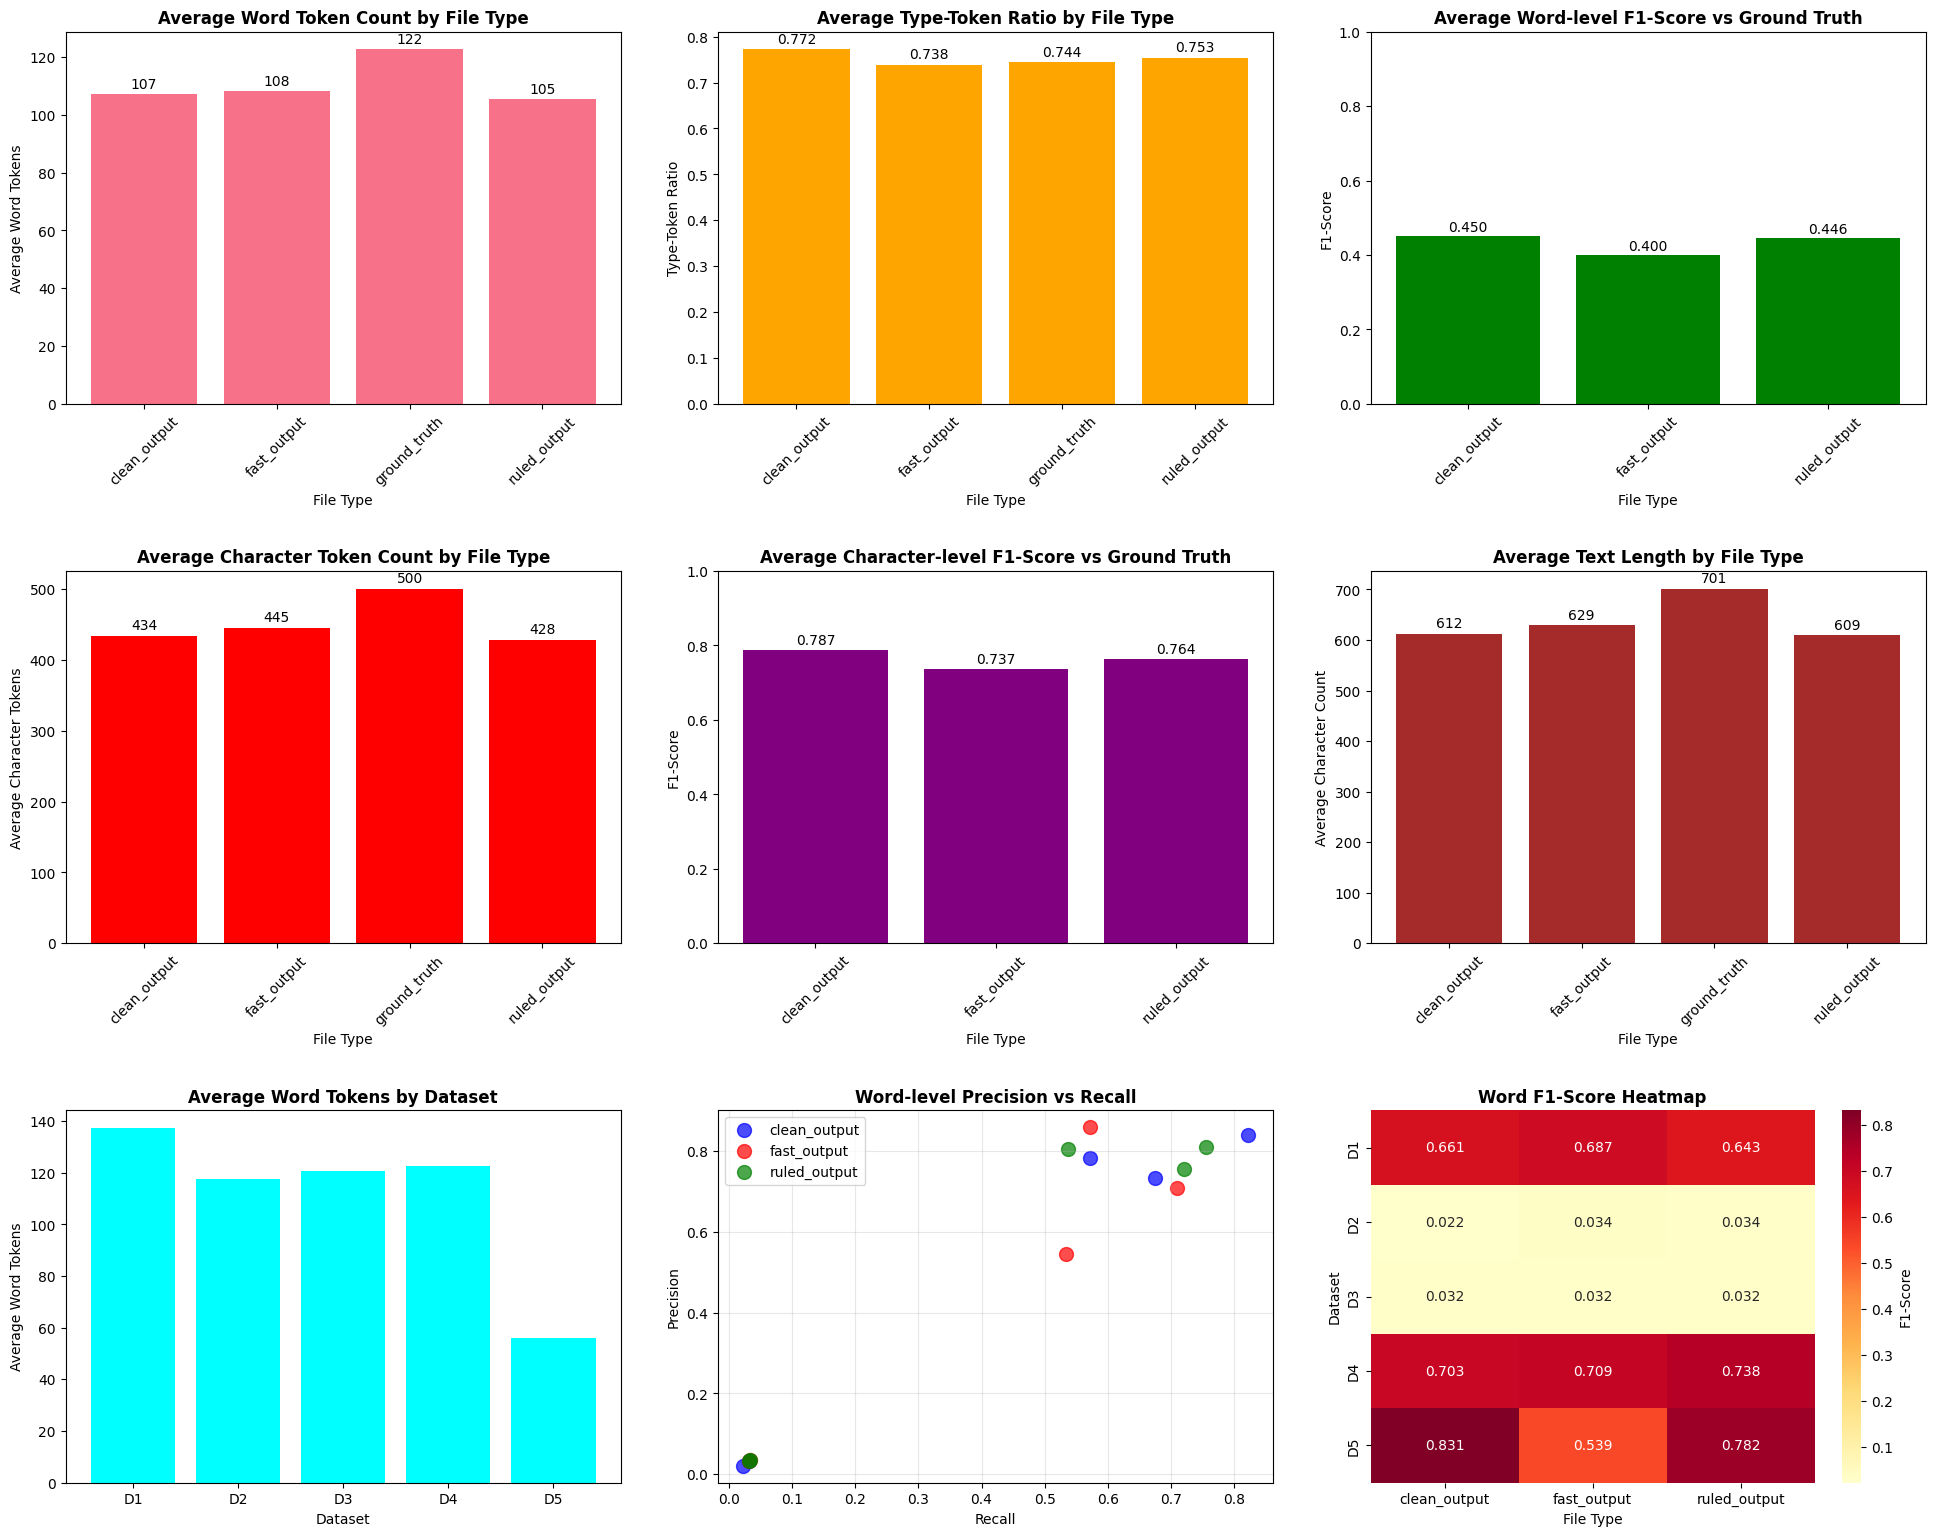

Comprehensive visualization completed!
Chart saved as: tokenization_analysis_charts.png


In [22]:
# Cell 14: Generate Visualizations
if results and comparisons and 'file_stats_df' in locals() and 'comparison_stats_df' in locals():
    print("Creating comprehensive visualizations...")
    create_visualizations(file_stats_df, comparison_stats_df)
else:
    print("Visualization data not available. Please run the analysis first.")

In [23]:
# Cell 15: Final Report Generation
def generate_final_report(results, comparisons, file_stats_df, comparison_stats_df):
    """Generate a comprehensive final report"""

    report = []
    report.append("=" * 100)
    report.append("COMPREHENSIVE BANGLA TOKENIZATION ANALYSIS REPORT")
    report.append("=" * 100)
    report.append(f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("")

    # Executive Summary
    report.append("EXECUTIVE SUMMARY")
    report.append("-" * 50)
    report.append(f"• Total datasets analyzed: {len(results)}")
    report.append(f"• Total files processed: {len(file_stats_df)}")
    report.append(f"• File types: {', '.join(file_stats_df['file_type'].unique())}")
    report.append("")

    # Best performing methods
    if not comparison_stats_df.empty:
        best_word_method = comparison_stats_df.loc[comparison_stats_df['word_f1_score'].idxmax()]
        best_char_method = comparison_stats_df.loc[comparison_stats_df['char_f1_score'].idxmax()]

        report.append("BEST PERFORMING METHODS:")
        report.append(f"• Word-level: {best_word_method['file_type']} (F1: {best_word_method['word_f1_score']:.3f})")
        report.append(f"• Character-level: {best_char_method['file_type']} (F1: {best_char_method['char_f1_score']:.3f})")
        report.append("")

    # Dataset-wise summary
    report.append("DATASET-WISE ANALYSIS")
    report.append("-" * 50)

    for dataset_name in sorted(results.keys()):
        report.append(f"\n{dataset_name}:")
        dataset_stats = file_stats_df[file_stats_df['dataset'] == dataset_name]

        for _, row in dataset_stats.iterrows():
            report.append(f"  {row['file_type']}:")
            report.append(f"    - Text length: {row['text_length']:,} characters")
            report.append(f"    - Word tokens: {row['word_total_tokens']:,}")
            report.append(f"    - Character tokens: {row['char_total_tokens']:,}")
            report.append(f"    - Word TTR: {row['word_type_token_ratio']:.3f}")

        # Add comparison results if available
        if not comparison_stats_df.empty:
            dataset_comparisons = comparison_stats_df[comparison_stats_df['dataset'] == dataset_name]
            if not dataset_comparisons.empty:
                report.append(f"  Comparison with Ground Truth:")
                for _, comp_row in dataset_comparisons.iterrows():
                    report.append(f"    {comp_row['file_type']}:")
                    report.append(f"      - Word F1: {comp_row['word_f1_score']:.3f}")
                    report.append(f"      - Char F1: {comp_row['char_f1_score']:.3f}")

    # Statistical summary
    report.append("\nSTATISTICAL SUMMARY")
    report.append("-" * 50)

    # Overall statistics
    total_chars = file_stats_df['text_length'].sum()
    total_word_tokens = file_stats_df['word_total_tokens'].sum()
    total_char_tokens = file_stats_df['char_total_tokens'].sum()

    report.append(f"Total characters processed: {total_chars:,}")
    report.append(f"Total word tokens generated: {total_word_tokens:,}")
    report.append(f"Total character tokens generated: {total_char_tokens:,}")
    report.append("")

    # Average performance by method
    if not comparison_stats_df.empty:
        avg_performance = comparison_stats_df.groupby('file_type')[['word_f1_score', 'char_f1_score']].mean()
        report.append("AVERAGE PERFORMANCE BY METHOD:")
        for method, scores in avg_performance.iterrows():
            report.append(f"  {method}:")
            report.append(f"    - Word F1: {scores['word_f1_score']:.3f}")
            report.append(f"    - Character F1: {scores['char_f1_score']:.3f}")
        report.append("")

    # Recommendations
    report.append("RECOMMENDATIONS")
    report.append("-" * 50)

    if not comparison_stats_df.empty:
        # Find best overall method
        avg_f1_scores = comparison_stats_df.groupby('file_type')[['word_f1_score', 'char_f1_score']].mean()
        avg_f1_scores['combined_f1'] = (avg_f1_scores['word_f1_score'] + avg_f1_scores['char_f1_score']) / 2
        best_overall = avg_f1_scores['combined_f1'].idxmax()

        report.append(f"1. Best overall method: {best_overall}")
        report.append(f"   (Combined F1: {avg_f1_scores.loc[best_overall, 'combined_f1']:.3f})")
        report.append("")

        # Performance insights
        word_f1_std = comparison_stats_df.groupby('file_type')['word_f1_score'].std()
        most_consistent = word_f1_std.idxmin()
        report.append(f"2. Most consistent method: {most_consistent}")
        report.append(f"   (Lowest std deviation: {word_f1_std[most_consistent]:.3f})")
        report.append("")

    report.append("3. For future improvements:")
    report.append("   - Consider ensemble methods combining best performers")
    report.append("   - Analyze error patterns in low-performing cases")
    report.append("   - Evaluate computational efficiency vs accuracy trade-offs")

    # Footer
    report.append("")
    report.append("=" * 100)
    report.append("END OF REPORT")
    report.append("=" * 100)

    # Save report
    report_text = "\n".join(report)
    with open('/content/drive/MyDrive/BT/REC_OUTPUTS/RES/comprehensive_tokenization_report.txt', 'w', encoding='utf-8') as f:
        f.write(report_text)

    # Print report
    print(report_text)

    return report_text


In [24]:
# Cell 16: Generate and Display Final Report
if results and comparisons and 'file_stats_df' in locals() and 'comparison_stats_df' in locals():
    print("Generating comprehensive final report...")
    final_report = generate_final_report(results, comparisons, file_stats_df, comparison_stats_df)
    print("\nReport saved as: comprehensive_tokenization_report.txt")

    # Create a summary of all generated files
    print("\n" + "="*60)
    print("GENERATED OUTPUT FILES:")
    print("="*60)
    print("1. comprehensive_tokenization_report.txt - Main analysis report")
    print("2. file_statistics_summary.csv - Statistical summary of all files")
    print("3. comparison_summary.csv - Comparison metrics summary")
    print("4. tokenization_analysis_charts.png - Comprehensive visualizations")
    print("\nAll files are saved in the /content/ directory")
    print("You can download them from the Colab file browser")

else:
    print("Cannot generate final report. Please ensure all previous steps completed successfully.")
    print("Make sure you have:")
    print("1. Loaded all datasets")
    print("2. Run the analysis pipeline")
    print("3. Generated summary statistics")

Generating comprehensive final report...
COMPREHENSIVE BANGLA TOKENIZATION ANALYSIS REPORT
Generated on: 2025-08-17 09:40:26

EXECUTIVE SUMMARY
--------------------------------------------------
• Total datasets analyzed: 5
• Total files processed: 20
• File types: ground_truth, clean_output, fast_output, ruled_output

BEST PERFORMING METHODS:
• Word-level: clean_output (F1: 0.831)
• Character-level: clean_output (F1: 0.956)

DATASET-WISE ANALYSIS
--------------------------------------------------

D1:
  ground_truth:
    - Text length: 1,106 characters
    - Word tokens: 185
    - Character tokens: 789
    - Word TTR: 0.746
  clean_output:
    - Text length: 743 characters
    - Word tokens: 129
    - Character tokens: 523
    - Word TTR: 0.783
  fast_output:
    - Text length: 750 characters
    - Word tokens: 122
    - Character tokens: 528
    - Word TTR: 0.754
  ruled_output:
    - Text length: 691 characters
    - Word tokens: 113
    - Character tokens: 483
    - Word TTR: 0.814

In [25]:
# Cell 17: Cleanup and Final Instructions
print("\n" + "="*80)
print("BANGLA TOKENIZATION ANALYSIS PIPELINE COMPLETED!")
print("="*80)
print("\nWhat was accomplished:")
print("✓ Processed multiple datasets (D1-D5)")
print("✓ Analyzed 4 file types per dataset (ground_truth, clean_output, fast_output, ruled_output)")
print("✓ Performed word-level and character-level tokenization")
print("✓ Generated comparative analysis against ground truth")
print("✓ Created comprehensive visualizations")
print("✓ Generated detailed statistical reports")

print("\nNext steps you can take:")
print("1. Download all generated files for further analysis")
print("2. Use the CSV files for custom analysis in other tools")
print("3. Share the comprehensive report with stakeholders")
print("4. Use insights to improve tokenization methods")

print("\nTo re-run with different data:")
print("1. Update DRIVE_BASE_PATH with your new dataset location")
print("2. Ensure file naming follows the pattern: DatasetName_FileType.txt")
print("3. Re-run cells 6 onwards")

print(f"\nThank you for using the Enhanced Bangla Tokenization Pipeline!")
print("="*80)


BANGLA TOKENIZATION ANALYSIS PIPELINE COMPLETED!

What was accomplished:
✓ Processed multiple datasets (D1-D5)
✓ Analyzed 4 file types per dataset (ground_truth, clean_output, fast_output, ruled_output)
✓ Performed word-level and character-level tokenization
✓ Generated comparative analysis against ground truth
✓ Created comprehensive visualizations
✓ Generated detailed statistical reports

Next steps you can take:
1. Download all generated files for further analysis
2. Use the CSV files for custom analysis in other tools
3. Share the comprehensive report with stakeholders
4. Use insights to improve tokenization methods

To re-run with different data:
1. Update DRIVE_BASE_PATH with your new dataset location
2. Ensure file naming follows the pattern: DatasetName_FileType.txt
3. Re-run cells 6 onwards

Thank you for using the Enhanced Bangla Tokenization Pipeline!
